## Project 2: Currency Predictor

### Prompt

*"Large companies often deal with foreign currency transactions while doing international business, and as a result, they are always looking for anything that can help them better understand the future direction and risk of various currencies. In this exercise, you will predict future movements in the value of the Japanese yen versus the U.S. dollar."*

### Approach

Overall, I'll take a first pass applying what I learn as I work through module 2, then follow up by comparing to public notebooks on Kaggle for gap analysis.

But first, we'll need to find the data. Luckily, [WSJ has historical prices for the USDJPY pair in a downloadable CSV](https://www.wsj.com/market-data/quotes/fx/USDJPY/historical-prices). I selected price data from December 2022 back to March 2006, which was the max range.


In [1]:
from numpy import float64
import pandas
data = pandas.read_csv('./data/USDJPY HistoricalPrices.csv',
                       names=['date', 'open', 'high', 'low', 'close'], header=0,
                       dtype={'open':float64, 'high':float64, 'low':float64, 'close':float64},
                       index_col='date', parse_dates=True,
                       engine='python')
data

,open,high,low,close
date,,,,
2022-12-30,133.02,133.09,130.78,131.12
2022-12-29,134.46,134.46,132.88,133.03
2022-12-28,133.50,134.50,133.38,134.48
2022-12-27,132.88,133.59,132.63,133.50
2022-12-26,132.76,133.24,132.31,132.88
...,...,...,...,...
2006-03-07,117.58,117.85,117.58,117.85
2006-03-06,116.38,117.58,116.38,117.58
2006-03-03,115.86,116.38,115.86,116.38


In [2]:
data.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,4393.0,105.269647,14.269503,75.83,96.81,107.94,113.89,150.14
high,4393.0,105.591571,14.366526,75.94,97.36,108.27,114.25,151.94
low,4393.0,104.926711,14.151276,75.83,96.36,107.63,113.48,149.56
close,4393.0,105.273337,14.274166,75.83,96.81,107.94,113.90,150.15


In [4]:
data = data.iloc[::-1] # reverse the curse
data

,open,high,low,close
date,,,,
2006-03-01,116.08,116.08,116.08,116.08
2006-03-02,116.08,116.08,115.86,115.86
2006-03-03,115.86,116.38,115.86,116.38
2006-03-06,116.38,117.58,116.38,117.58
2006-03-07,117.58,117.85,117.58,117.85
...,...,...,...,...
2022-12-26,132.76,133.24,132.31,132.88
2022-12-27,132.88,133.59,132.63,133.50
2022-12-28,133.50,134.50,133.38,134.48


In [5]:
pandas.options.mode.chained_assignment = None # suppress SettingWithCopyWarning, default = 'warn'
data['change'] = data.close - data.open
data['pct'] = data.close.pct_change()
data['ma30'] = data.close.rolling(30).mean()
data['ma90'] = data.close.rolling(90).mean()
data

,open,high,low,close,change,pct,ma30,ma90
date,,,,,,,,
2006-03-01,116.08,116.08,116.08,116.08,0.00,NaN,NaN,NaN
2006-03-02,116.08,116.08,115.86,115.86,-0.22,-0.001895,NaN,NaN
2006-03-03,115.86,116.38,115.86,116.38,0.52,0.004488,NaN,NaN
2006-03-06,116.38,117.58,116.38,117.58,1.20,0.010311,NaN,NaN
2006-03-07,117.58,117.85,117.58,117.85,0.27,0.002296,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-26,132.76,133.24,132.31,132.88,0.12,0.000678,137.051333,141.847444
2022-12-27,132.88,133.59,132.63,133.50,0.62,0.004666,136.857667,141.811333
2022-12-28,133.50,134.50,133.38,134.48,0.98,0.007341,136.689000,141.781889


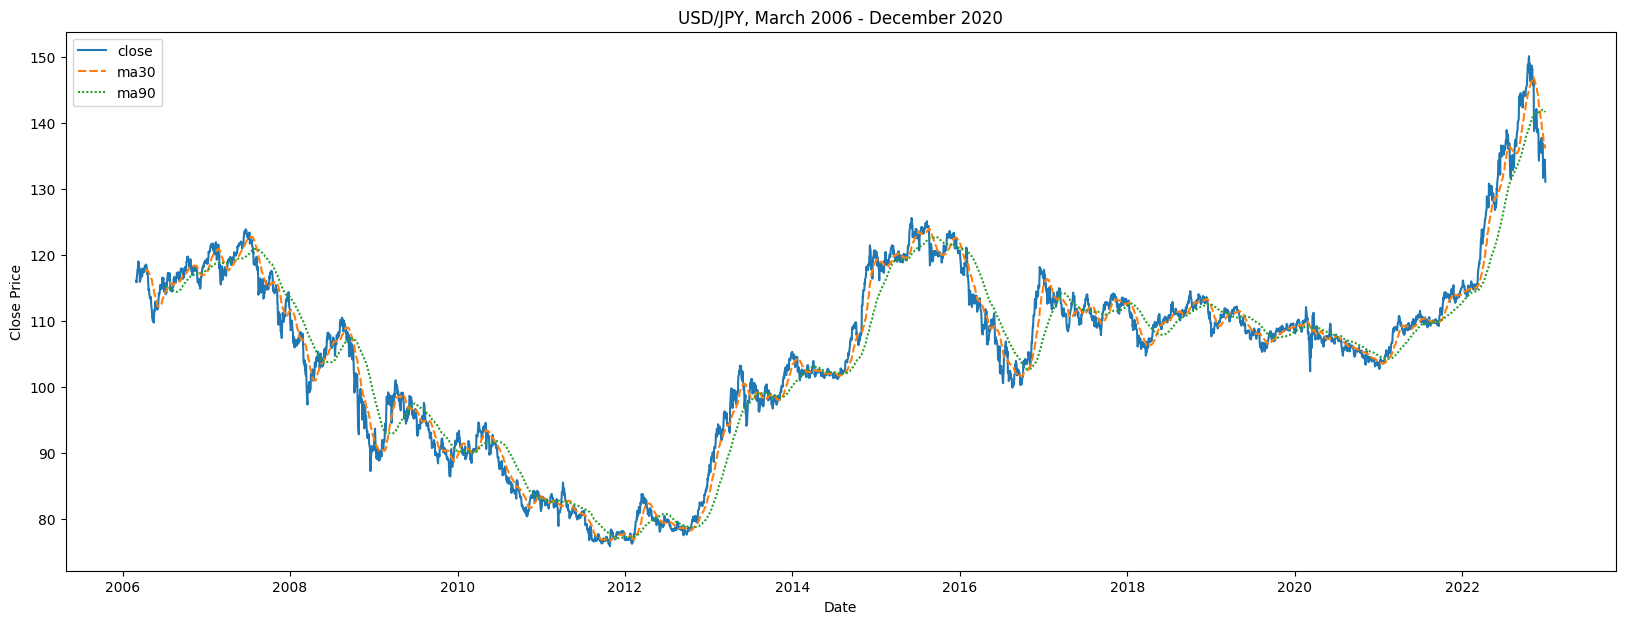

In [22]:
import matplotlib.pyplot as matplot
import seaborn
matplot.figure(figsize=(20, 7))
matplot.title('USD/JPY, March 2006 - December 2020')
seaborn.lineplot(data=data[['close', 'ma30', 'ma90']])
matplot.ylabel('Close Price')
matplot.xlabel('Date')
pass # hide matplot.xlabel() output